In [3]:
from __future__ import (division, print_function, absolute_import)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [8]:
v=.5
class LorentzTrafo:
    def __init__(self, v):
        self.v = v
        self.gamma = np.sqrt(1-v*v)
        self.matrix = self.gamma * np.array([[1, -v], [-v, 1]])
        
    def __call__(self, p):
        """
        Takes an array of spacetime coordinates [(t1, x1), (t2, x2), ...]
        and returns their Lorentz-boosted image
        """
        return np.matmul(self.matrix, np.transpose(p)).T
        
lt = LorentzTrafo(v)
res = lt([[4,2], [6,3]])
res[0], res[1]

(array([2.59807621, 0.        ]), array([ 3.89711432e+00, -2.22044605e-16]))

In [393]:
lt.matrix

array([[ 0.8660254, -0.4330127],
       [-0.4330127,  0.8660254]])

In [19]:
class MinkowskiGrid:
    
    def __init__(self, first, last, left, right, step, v=0.5):
    
        N_wl = 10
        
        self.line_color = '#F0C0C0'

        self.left = left
        self.right = right
        self.first = first
        self.last = last
        self.step = step
        self.v = v
        
        tr = range(first, last+1)
        self.xlines = [[[t, left], [t, right]] for t in range(first, last+1)]

        xr = range(left, right+1)
        self.tlines = [[[first, x], [last, x]] for x in range(left, right+1)]

        self.lines = np.append(self.xlines, self.tlines)
        
        self.points = np.array([(t, x) for x in range(left, right+1) 
                       for t in range(first, last+1)])

        self.other = list(zip(np.linspace(first, last, N_wl),
             np.linspace(first*v, last*v, N_wl)))

        self.mytime = [(t, 0) for t in np.linspace(0, last, N_wl)]
        
        r = list(zip(np.linspace(0, last, N_wl),
             np.linspace(0, last, N_wl)))
        l = list(zip(np.linspace(0, last, N_wl),
             np.linspace(0, -last, N_wl)))
        self.light_cone = np.append(r, l, axis=0)
        
        
    @staticmethod
    def is_light(p):
        return math.fabs(p[0])==p[1]

    @staticmethod
    def is_mytime(p):
        return p[0]==0



In [24]:
class MinkowskiPlot():

    def __init__(self, grid):
        self.grid = grid
    
    @staticmethod
    def to_mpl_lines(minkowski_lines, color):
        return np.array([[
            [p[0][1], p[1][1]], 
            [p[0][0], p[1][0]], 
            color] 
            for p in minkowski_lines]).reshape(-1)
        
    @staticmethod
    def to_mpl(tx):
        return np.transpose(zip(np.transpose(tx)[1],np.transpose(tx)[0]))
        
    def points_xy(self):
        return np.array(list(zip(self.grid.points.T[1], self.grid.points.T[0]))).T

    def mytime_xy(self):
        return self.to_mpl(grid.mytime)
        return np.array([p for p in self.points_xy().T if self.grid.is_mytime(p)])

    def light_xy(self):
        return self.to_mpl(grid.light_cone)

    def other_xy(self):
        return self.to_mpl(grid.other)

    def tlines_xy(self, color):
        return self.to_mpl_lines(self.grid.tlines, color)
    
    def xlines_xy(self, color):
        return self.to_mpl_lines(self.grid.xlines, color)
    
    def any_xy(self):
        return np.array([p for p in self.points_xy().T if not self.grid.is_light(p) 
                         and not self.grid.is_other(p) 
                         and not self.grid.is_mytime(p)])    

    def plot_grid(self, axis, color='#FFC0C0'):
        axis.plot([self.grid.left, self.grid.right], [0, 0], 'k');
        axis.plot(*self.tlines_xy(color));
        axis.plot(*self.xlines_xy(color));

    def plot_mytime(self, axis, color='r'):
        axis.scatter(*self.mytime_xy(), color=color, marker='o', s=80);
        axis.plot([0,0], [self.grid.first, self.grid.last], color);
    
    def plot_lightcone(self, axis, color='y'):
        axis.plot([self.grid.left, 0, self.grid.right], 
                  [self.grid.last, 0, self.grid.last], 'y');
        axis.scatter(*self.light_xy(), color='y', marker='o', s=80);
    
    def plot_other(self, axis, color='b'):
        axis.plot([0,self.grid.v*self.grid.right], [0, self.grid.right], color);        
        axis.scatter(*self.other_xy(), color=color, marker='o', s=80);
    
    def display(self, axis):
        self.plot_grid(axis, '#FFC0C0')
        self.plot_mytime(axis, 'r')
        self.plot_lightcone(axis, 'y')
        self.plot_other(axis, 'b')

    

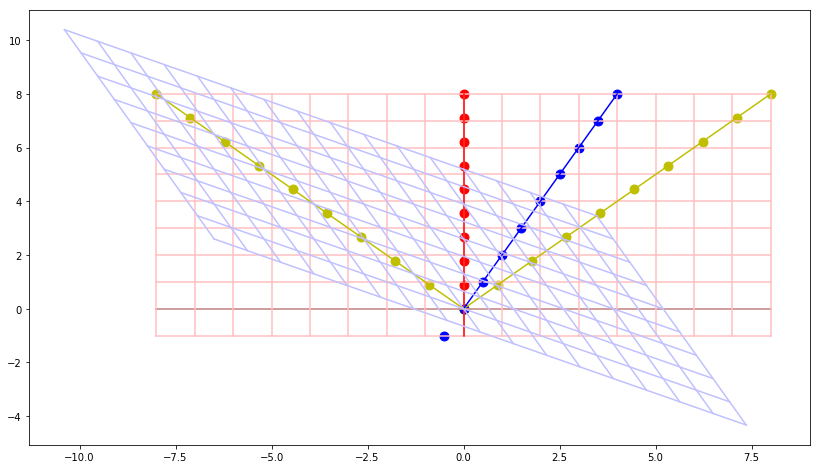

In [26]:
grid = MinkowskiGrid(-1, 8, -8, 8, 1, .5)
minkowski = MinkowskiPlot(grid)
_, axis = plt.subplots(figsize=(14,8))
minkowski.display(axis)


tlines_d=np.array([lt(pair) for pair in grid.tlines])
tlines_d=MinkowskiPlot.to_mpl_lines(tlines_d, '#C0C0FF')
xlines_d=np.array([lt(pair) for pair in grid.xlines])
xlines_d=MinkowskiPlot.to_mpl_lines(xlines_d, '#C0C0FF')

axis.plot(*xlines_d);
axis.plot(*tlines_d);
#axis.scatter(*another, color='b', marker='o', s=80);